In [1]:
!pip uninstall tensorflow

Uninstalling tensorflow-2.2.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.2.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.2.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%cd drive
%cd My Drive
%cd dataset_pet

/content/drive
/content/drive/My Drive
/content/drive/My Drive/dataset_pet


In [0]:
ls

checkpoints/        detect.py        pre_train.record      train.py
conda-gpu.yml       detect_video.py  requirements-gpu.txt  xml_to_csv.py
convert.py          docs/            setup.py              yolov3_tf2/
custom_train.ipynb  logs/            tf_record.py          yolov3_tf2.egg-info/
data/               pre_test.record  tools/


In [4]:
#!git clone https://github.com/zzh8829/yolov3-tf2
!pip install -r requirements-gpu.txt

Obtaining file:///content/drive/My%20Drive/dataset_pet (from -r requirements-gpu.txt (line 6))
     |████████████████████████████████| 421.8MB 40kB/s 
     |████████████████████████████████| 28.7MB 117kB/s 
     |████████████████████████████████| 3.9MB 51.8MB/s 
     |████████████████████████████████| 450kB 47.1MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=d405b4ff362c6ebd6c51c372079a32960bef12a84342429315f55b63b41b7b19
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: g

In [0]:
#!wget https://pjreddie.com/media/files/yolov3.weights -O data/yolov3.weights
!python convert.py

In [0]:
import sys
from absl import app, logging, flags
from absl.flags import FLAGS
import time
import cv2
import numpy as np
import tensorflow as tf
from yolov3_tf2.models import (
    YoloV3, YoloV3Tiny
)
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs

flags.DEFINE_string('classes', './data/coco.names', 'path to classes file')
flags.DEFINE_string('weights', './checkpoints/yolov3.tf',
                    'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('image', './data/girl.png', 'path to input image')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_string('output', './output.jpg', 'path to output image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')

app._run_init(['yolov3'], app.parse_flags_with_usage)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [0]:
FLAGS.image = 'data/girl.png'
FLAGS.weights= 'weight/yolov3-tiny.tf'
FLAGS.tiny=True
if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)
      
yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')

img_raw = tf.image.decode_image(
    open(FLAGS.image, 'rb').read(), channels=3)

img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
logging.info('time: {}'.format(t2 - t1))

logging.info('detections:')
for i in range(nums[0]):
    logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                        np.array(scores[0][i]),
                                        np.array(boxes[0][i])))

img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

from IPython.display import Image, display
display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))




In [0]:
#--mode fit --transfer darknet \
--mode fit --transfer fine_tune \
#--weights_num_classes 2 

In [0]:
!python train.py \
	--dataset ./dataset/multi_train03.record \
	--val_dataset ./dataset/multi_test03.record \
	--classes ./data/custom_1.names \
	--num_classes 2 \
	--mode fit \
	--transfer fine_tune \
	--batch_size 15 \
	--epochs 20 \
	--weights ./checkpoints/multi_8_18.tf \
	--learning_rate 1e-5

2020-05-14 03:12:17.382705: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-05-14 03:12:17.382800: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-05-14 03:12:17.382818: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2020-05-14 03:12:18.233592: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-05-14 03:12:18.236013: I tensorflow/stream_executor/cuda/cuda_g

In [0]:
!python train.py \
	--dataset ./dataset/multi_train02.record \
	--val_dataset ./dataset/multi_test02.record \
	--classes ./data/custom_1.names \
	--num_classes 2 \
	--mode fit \
	--transfer fine_tune \
	--batch_size 15 \
	--epochs 50 \
	--weights ./checkpoints/tiny_6_11.tf \
	--learning_rate 1e-6 \
	--outname ds\
	--weights_num_classes 2 \
  --tiny True

I0518 05:34:43.502288 139921809696640 <ipython-input-28-a84a2f4ac03a>:23] weights loaded
I0518 05:34:43.735501 139921809696640 <ipython-input-28-a84a2f4ac03a>:26] classes loaded
I0518 05:34:45.033701 139921809696640 <ipython-input-28-a84a2f4ac03a>:37] time: 0.18861865997314453
I0518 05:34:45.034507 139921809696640 <ipython-input-28-a84a2f4ac03a>:39] detections:
I0518 05:34:45.042220 139921809696640 <ipython-input-28-a84a2f4ac03a>:43] 	PET, 0.9972435832023621, [0.40992606 0.         0.68220055 0.9902397 ]
I0518 05:34:45.048128 139921809696640 <ipython-input-28-a84a2f4ac03a>:43] 	can, 0.37084031105041504, [0.7465124  0.19053337 0.9091573  0.8357612 ]
I0518 05:34:45.051272 139921809696640 <ipython-input-28-a84a2f4ac03a>:43] 	can, 0.31003138422966003, [0.01192186 0.13183203 0.2159406  0.75132656]
I0518 05:34:45.054641 139921809696640 <ipython-input-28-a84a2f4ac03a>:43] 	can, 0.2470499724149704, [0.21423411 0.13171956 0.4296193  0.7493706 ]


(795, 435)
(1205, 450)
(165, 387)
(468, 386)


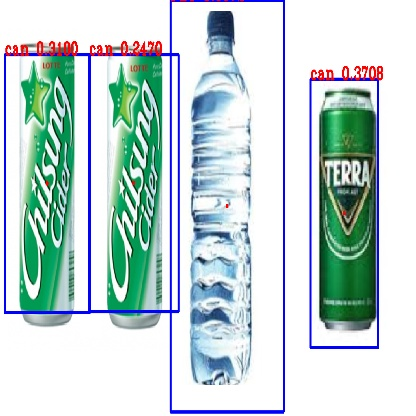

In [28]:
from yolov3_tf2.utils import draw_outputs

FLAGS.num_classes = 2
FLAGS.classes = 'data/custom_2.txt'
#FLAGS.weights = 'weight/multi_07.tf'
FLAGS.weights = 'checkpoints/multi_9_5.tf'
FLAGS.image = 'data/model_test05.png'
#FLAGS.image = 'data/can_test01.jpg'
#FLAGS.image = 'data/pet_test01.jpg'
#FLAGS.image='data/test01.jpg'
FLAGS.tiny=False

# Lower threshold due to insufficient training
FLAGS.yolo_iou_threshold = 0.5
FLAGS.yolo_score_threshold = 0.1

if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)

yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')

img_raw = tf.image.decode_image(
    open(FLAGS.image, 'rb').read(), channels=3)

img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
logging.info('time: {}'.format(t2 - t1))

logging.info('detections:')
for i in range(nums[0]):
    logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                        np.array(scores[0][i]),
                                        np.array(boxes[0][i])))

img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
img = cv2.resize(img,(416,416))
cv2.imwrite('output.png',img)
from IPython.display import Image, display
display(Image(data=bytes(cv2.imencode('.jpg', img)[1])))

In [0]:
!python visualize_dataset.py --dataset= multi_train03.record --classes= custom_1.names

2020-05-13 01:33:01.682006: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-05-13 01:33:01.682117: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-05-13 01:33:01.682134: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Traceback (most recent call last):
  File "visualize_dataset.py", line 61, in <module>
    app.run(main)
  File "/usr/local/lib/python3.6/dist-packages/absl/app.py", line 299, in run
    _run_main(main, args)


/content/drive/My Drive/dataset_pet
